## Diseño Evolutivo de Redes Neuronales Artificiales
## Evolutionary Design of Artificial Neural Networks
## DERNA/EDANN
Some code based on [Time Series Prediction A Naive Exploration](https://www.researchgate.net/profile/Wilson_Tolentino_Da_Silva2/publication/333982520_Time_Series_Prediction_A_Naive_Exploration/links/5d10ec94299bf1547c7afe08/Time-Series-Prediction-A-Naive-Exploration.pdf)

The objective of this program is to optimize the published code (baseline_tolentino_original) using EDANN.<br>
On the paper, Tolentino achieves a Test loss of 0.10234724577159098<br>
My reproduction of the program achieves 0.06509439647197723<br>
The objective of this program is to outperform those numbers.<br>

This is the first try to integrate the Genetic Algorithm and the ANN.

V 1.0 2020-08-11 Reescritura completa de cero de DERNA, ahora usa arreglos de reales, mapeo, alpha blend y mutación por perturbación o random.

### Setup

#### Install packages

In [ ]:
!pip install -U deap

#### Import libraries and functions

In [ ]:
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn.preprocessing as skp
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

from deap import base, creator, tools, algorithms

#### Hyperparameters

In [ ]:
# define hyperparameters
p = {
     "Window": 1,  # this will be optimized by the GA
     "Neurons": 12,  # this will be optimized by the GA
     "test_split" : 0.10,  # testing ***
     "val_split" : 0.0,  # no validation ***
     "activation": "relu",  # for the hidden layer
     # could be relu, sigmoid, softmax, softplus, softsign, tanh, selu,
     # elu, exponential, or linear
     "output_activation": "linear",  # for the output layer
     "loss": "logcosh",  # could be mse, mae, msle, cs, huber, or logcosh
     "optimizer": "nadam",  # could be sgd, rmsprop, adam, adadelta,
     # adagrad, adamax, nadam, or ftrl
     # or a class instance with sub-parameters like
     # tf.keras.optimizers.SGD(
     #    learning_rate=0.3,
     #    momentum=0.2,
     #    nesterov=False),
     "epochs": 20,  # training epochs
     "batch_size": 1,  # ***
     #"batch_size": 30,
     "shuffle": False,  # the training data ***
     #"shuffle": True,  # the training data
     "verbose": 0,  # verbose training, 1 is too chatty, 2 may be convenient
     "population" : 25,  # *** number of individuals in population
     #"population" : 75,  # number of individuals in population
     # should be chosen based on the size of the optimization space
     # (better high around sqrt(space size))
     "ngen" : 6,  # *** number of generations (just high enough)
     #"ngen" : 30,  # number of generations (just high enough)
     # EDANN does no redundant evaluations
     "ngenes" : 2,  # number of genes in a chromosome
     "genes" : ("Window", "Neurons"),
     "min" : (1, 10),  # minimun value of each gene
     "range" : (30, 30),  # *** range of values of each gene
     #"range" : (200, 30),  # range of values of each gene
     "alpha" : 0.2,  # alpha blend oversize (better not too high)
     "sigma": 0.1,  # for gaussian mutation
     "indpb": 0.2,  # for gaussian mutation
     "tournsize" : 3,  # tournament size
     "cxpb" : 0.6,  # crossover probability (better high)
     "mutpb" : 0.2,  # mutation probability (better low)
    }

#### Read data from repository

In [ ]:
# copy file from repository
path_to_downloaded_file = tf.keras.utils.get_file(
    "baseline_tolentino.csv",
    "https://raw.githubusercontent.com/jmacostap/webstore/master/"+
    "baseline_tolentino.csv",
    cache_dir="/content",
    )
# load data into a Pandas dataframe
df = pd.read_csv(path_to_downloaded_file)
print(len(df), "lines read")

4829 lines read


#### Add new columns and drop unused

In [ ]:
# drop columns that will not be used
df.drop(["Date", "Open", "High", "Low", "Volume"], axis=1, inplace=True)

#### Split data into train and test sets

In [ ]:
# Split the data and convert to 2D Numpy Arrays for MinMaxScaler
test_split = int(len(df) * (1.0 - p["test_split"]))
train = df.iloc[:test_split].values.reshape(-1,1)
test = df.iloc[test_split:].values.reshape(-1,1)

#### Scale data to [-1, 1]

In [ ]:
# scale data
scaler = skp.MinMaxScaler(feature_range=(-1, 1))  # ***
#scaler = skp.MinMaxScaler(feature_range=(0, 1))
# it should fit using both arrays, not only train
scaler.partial_fit(train)
scaler.partial_fit(test)
train_scaled = scaler.transform(train).flat
test_scaled = scaler.transform(test).flat

#### Auxiliary functions definition

##### Prepare a time series into sliding windows

In [ ]:

def prepare_time_series(time_series, targets, window):
    """Prepare time series and targets for Keras
    # like tf.keras.preprocessing.sequence.TimeseriesGenerator
    # without the batches
    # In the basic case time_series and targets are the same array

    Args:
    time_series: flat array-like: of values of the time series
    targets: flat array-like: of target values
    X[0] = time_series[0:window]
    Y[0] = targets[window]
    and so on
    
    Returns:
    X: 2D ndarray: of dataset_length vectors of window elements
    Y: 1D ndarray: of targets[window:]
    """

    # *** falta considerar el tamaño de columns o es otra dimensión de X?

    dataset_length = len(time_series) - window
    X = np.empty((dataset_length, window))
    Y = np.empty((dataset_length, 1))
    for i in range(dataset_length):
        X[i, :] = time_series[i:(i + window)]
        Y[i, 0] = targets[i + window]
    return X, Y



##### Create train and test an ANN

In [ ]:

def create_ann(p, train_data, targets):
    """Create an ANN with the parameters on p and train it with train_data

    Args:
    p: dict: of hyperparameters
    train_data: flat array-like: of training data
    targets: flat array-like: of targets
    
    Returns:
    ann: keras.model: the trained neural network
    history: keras.history: the training history
    """

    X_train, y_train = prepare_time_series(
        train_data, targets, p["Window"])
    # ensure reproducibility and consistency across fenotypes
    tf.random.set_seed(31415926)

    ann = Sequential([Dense(units=p["Neurons"],
                            input_dim=p["Window"],
                            activation=p["activation"]),
                      Dense(units=1,
                            activation=p["output_activation"])])

    ann.compile(loss=p["loss"], optimizer=p["optimizer"])

    history = ann.fit(x=X_train,
                      y=y_train,
                      epochs=p["epochs"],
                      batch_size=p["batch_size"],
                      verbose=p["verbose"],
                      validation_split=p["val_split"],
                      shuffle=p["shuffle"])
    
    return ann, history



##### Graphically display the performance of a trained ANN

In [ ]:

def display_ann(ann, history, window, batch_size, train_data, test_data):
    """Show the ANN performance with graphs

    Args:
    ann: keras.model: the trained neural network
    history: keras.history: the training history
    window: int: the window size used on ann
    batch_size: int: the batch_size used on ann
    train_data: flat array-like: the train data used for ann.
                Needed for the plots
    test_data: flat array-like: data to test the ann

    Returns:
    Nothing
    """

    import matplotlib.pyplot as plt

    X_train, y_train = prepare_time_series(
        train_data, train_data, window)
    X_test, y_test = prepare_time_series(
        test_data, test_data, window)

    ann_train_loss = ann.evaluate(x=X_train,
        y=y_train,
        batch_size=batch_size)
    ann_test_loss = ann.evaluate(x=X_test,
        y=y_test,
        batch_size=batch_size)
    y_train_pred = ann.predict(X_train)
    y_test_pred = ann.predict(X_test)

    # Show various scores
    from sklearn.metrics import r2_score
    from sklearn.metrics import mean_squared_error
    print("ANN train: {}".format(ann_train_loss))
    print("ANN test: {}".format(ann_test_loss))
    print("R2 score of a trivial predictor on train data:\t{:0.8f}".
          format(r2_score(y_train[1:], y_train[:-1])))
    print("R2 score of a trivial predictor on test data:\t{:0.8f}".
          format(r2_score(y_test[1:], y_test[:-1])))
    print("MSE of a trivial predictor on train data:\t{:0.8f}".
          format(mean_squared_error(y_train[1:], y_train[:-1])))
    print("MSE of a trivial predictor on test data:\t{:0.8f}".
          format(mean_squared_error(y_test[1:], y_test[:-1])))
    print("The R2 score on the Train set is:\t{:0.8f}".
          format(r2_score(y_train, y_train_pred)))
    print("The R2 score on the Test set is:\t{:0.8f}".
          format(r2_score(y_test, y_test_pred)))
    print("MSE of the trained ANN on train data:\t{:0.8f}".
          format(mean_squared_error(y_train, y_train_pred)))
    print("MSE of the trained ANN on test data:\t{:0.8f}".
          format(mean_squared_error(y_test, y_test_pred)))

    # show the data in a graph
    plt.figure(figsize=(20, 12))
    plt.subplot(1,2,1)
    plt.plot(range(test_split), train_data, label="train")
    plt.plot(range(test_split, len(df)), test_data, label="test")
    plt.plot(range(window, window + len(y_train_pred)),
             y_train_pred, label="trained")
    plt.plot(range(window + test_split, window + test_split + len(y_test_pred)),
             y_test_pred, label="test prediction")
    plt.title("Original data and ANN predictions")
    plt.xlabel("Observation")
    plt.ylabel("S&P500 Close Daily scaled")
    plt.legend()
    #plt.show()

    # graph Train and Validation loss evolution
    skip = 4  # Avoid autoscale issues
    #plt.figure(figsize=(10,12))
    plt.subplot(122)
    plt.plot(history.history["loss"][skip:], "g",
             label="Training loss")
    if (p["val_split"] != 0.0):
        plt.plot(history.history["val_loss"][skip:], "b",
                 label="Validation loss")
    plt.title("Loss evolution during training")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()



##### Create and evaluate the ANN described by a chromosome

In [ ]:

def evaluate_chromosome(chromosome, p=None, train_data=None, targets=None,
                        seen_fenotypes=None):
    """Build, train and evaluate an ANN represented by a chromosome
    Extract the fenotype from the chromosome
    If it has been previously evaluated return the loss immediately
    otherwise create train and evaluate the ann
    save the training and validation loss

    Args:
    chromosome: list of genes: each gene is a float that describes an
                ANN feature
    p: dict: of hyperparameters
    train_data: flat array-like: data for training
    targets: flat array-like: targets for training
    seen_fenotypes: dictionary: evaluated fenotypes and their losses

    Returns:
    (float,): Validation loss
    """

    # ensure reproducibility
    tf.random.set_seed(31416)  # Keras

    # extract fenotype
    fenotype = tuple(
        [int(chromosome[i] * p["range"][i] + p["min"][i])
        for i in range(p["ngenes"])])

    # set hyperparameters
    for i in range(p["ngenes"]):
        p[p["genes"][i]] = fenotype[i]

    # display fenotype
    for i, j in zip(p["genes"], fenotype):
        print(i, j, "", end="")
    print("")

    # avoid evaluating the same fenotype twice
    if fenotype in seen_fenotypes:
        return seen_fenotypes[fenotype][0],

    # Build the ANN
    model, history = create_ann(p, train_scaled, train_scaled)

    # extract and display training and validation loss
    if (p["val_split"] != 0.0):
        val_loss = history.history["val_loss"][-1]
        loss = history.history["loss"][-1]
        print("Training error: {} Validation error: {}".format(loss, val_loss))
        seen_fenotypes[fenotype] = val_loss, loss
        return val_loss,
    else:
        loss = history.history["loss"][-1]
        print("Training error: {}".format(loss))
        seen_fenotypes[fenotype] = loss,
        return loss,

#### Create the fitness definition

In [ ]:
# Fitness tries to maximize we need to use negative weight to minimize
#creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


#### Define the rest of the genetic operators on the toolbox

In [ ]:
toolbox = base.Toolbox()
toolbox.register("attr_float", random.random)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_float, n=p["ngenes"])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def checkBounds(min, max):
    """Decorator to adjust the gene value in case it is out of bounds

    Args:
    min: minimum value
    max: maximum value

    Returns:
    The function that checks bounds to decorate mate or mutate on the toolbox
    """

    def decorator(func):
        def wrapper(*args, **kargs):
            offspring = func(*args, **kargs)
            for child in offspring:
                for i in range(len(child)):
                    if child[i] > max:
                        child[i] = max
                    elif child[i] < min:
                        child[i] = min
            return offspring
        return wrapper
    return decorator


# mate by Alpha Blend
toolbox.register("mate", tools.cxBlend, alpha=p["alpha"])
# stay within [0,1)
toolbox.decorate("mate", checkBounds(0.0, 0.9999999999999999))
# mutate by gaussian perturbation
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=p["sigma"],
                 indpb=p["indpb"])
# stay within [0,1)
toolbox.decorate("mutate", checkBounds(0.0, 0.9999999999999999))
toolbox.register("select", tools.selTournament, tournsize=p["tournsize"])
# initialize seen list to avoid multiple evaluations
seen_fenotypes = {}
toolbox.register("evaluate", evaluate_chromosome, p=p, train_data=train_scaled,
                 targets=train_scaled, seen_fenotypes=seen_fenotypes)



### The GA

#### Run the GA

In [ ]:
# Ensure reproducibility
random.seed(31416) # DEAP uses random

# reset list to avoid multiple evaluations
seen_fenotypes = {}

population = toolbox.population(n=p["population"])
algorithms.eaSimple(population, toolbox, cxpb=p["cxpb"], mutpb=p["mutpb"],
                        ngen=p["ngen"], verbose=True)

Window 16 Neurons 39 
Training error: 0.0001499890349805355
Window 20 Neurons 35 
Training error: 0.00015347424778155982
Window 14 Neurons 31 
Training error: 0.00014299344911705703
Window 16 Neurons 30 
Training error: 0.000152501612319611
Window 1 Neurons 23 
Training error: 0.00011510327749419957
Window 26 Neurons 29 
Training error: 0.0001768884831108153
Window 8 Neurons 27 
Training error: 0.00012912396050523967
Window 12 Neurons 38 
Training error: 0.0001235245435964316
Window 17 Neurons 15 
Training error: 0.0001544430124340579
Window 30 Neurons 25 
Training error: 0.0001994877093238756
Window 8 Neurons 34 
Training error: 0.0001292212982662022
Window 19 Neurons 27 
Training error: 0.00015174240979831666
Window 9 Neurons 10 
Training error: 0.00012738810619339347
Window 16 Neurons 17 
Training error: 0.00016013585263863206
Window 24 Neurons 25 
Training error: 0.00016880665498320013
Window 30 Neurons 11 
Training error: 0.0001726385671645403
Window 19 Neurons 38 
Training error:

([[0.17260085599560085, 0.49367248190968904],
  [0.10775299925344485, 0.500076667934382],
  [0.009124658751630271, 0.46528776042274334],
  [0.008643432969556953, 0.6051103884767146],
  [0.2802631530123605, 0.25076697665958136],
  [0.3028412047900346, 0.4196377154989582],
  [0.009094127543110137, 0.6141192597422693],
  [0.009201119527971773, 0.37582132367763893],
  [0.008673964178077087, 0.4562788891571887],
  [0.27570505115997423, 0.4141452258931469],
  [0.27570505115997423, 0.41414522589314684],
  [0.27570505115997423, 0.41414522589314684],
  [0.22995529197052667, 0.35443346500833506],
  [0.04497843735573342, 0.4689008795355624],
  [0.3107623320627914, 0.12190996759369613],
  [0.27636718582860925, 0.45141512836911435],
  [0.009201119527971773, 0.2450697349250337],
  [0.266259765148183, 0.3670554553867088],
  [0.27554169246317545, 0.4327976002513077],
  [0.0, 0.39053674429258983],
  [0.27570505115997423, 0.4141452258931469],
  [0.27570505115997423, 0.4141452258931469],
  [0.26625976514

#### Show the best solutions

In [ ]:
best_individuals = tools.selBest(population, k=len(population))
# extract best fenotype
best_ann = tuple(
    [int(best_individuals[0][i] * p["range"][i] + p["min"][i])
    for i in range(len(best_individuals[0]))])
best_window_size = best_ann[0]

for chromosome in best_individuals:
    # extract fenotype
    fenotype = tuple(
        [int(chromosome[i] * p["range"][i] + p["min"][i])
        for i in range(len(chromosome))])
    
    for i, j in zip(p["genes"], fenotype):
        print(i, j, "", end="")
    print("")


Window 1 Neurons 17 
Window 1 Neurons 23 
Window 1 Neurons 23 
Window 1 Neurons 23 
Window 8 Neurons 21 
Window 8 Neurons 21 
Window 9 Neurons 22 
Window 9 Neurons 22 
Window 9 Neurons 22 
Window 9 Neurons 22 
Window 9 Neurons 22 
Window 9 Neurons 22 
Window 1 Neurons 28 
Window 1 Neurons 28 
Window 1 Neurons 21 
Window 1 Neurons 21 
Window 10 Neurons 22 
Window 9 Neurons 17 
Window 8 Neurons 24 
Window 7 Neurons 20 
Window 2 Neurons 24 
Window 10 Neurons 13 
Window 6 Neurons 24 
Window 4 Neurons 25 
Window 9 Neurons 23 


#### Train the best individual and test it

In [ ]:
# Here it could create a larger training dataset by setting val_split to 0.0

# set hyperparameters according to best_ann
for i in range(p["ngenes"]):
    p[p["genes"][i]] = best_ann[i]

# Build the ANN
ann, history = create_ann(p, train_scaled, train_scaled)

# Display training and validation losses
if (p["val_split"] != 0.0):
    print("Training error: {} Validation error: {}".
          format(history.history["loss"][-1], history.history["val_loss"][-1]))
else:
    print("Training error: {}".format(history.history["loss"][-1]))

Training error: 0.00011302387429168448


#### Display the best ann

482/482 [==============================] - 1s 1ms/step - loss: 0.0082
ANN train: 0.02494564652442932
ANN test: 0.008236409164965153
R2 score of a trivial predictor on train data:	0.99841152
R2 score of a trivial predictor on test data:	0.97704959
MSE of a trivial predictor on train data:	0.00017872
MSE of a trivial predictor on test data:	0.00041569
The R2 score on the Train set is:	0.54943965
The R2 score on the Test set is:	0.09272322
MSE of the trained ANN on train data:	0.05067952
MSE of the trained ANN on test data:	0.01654942


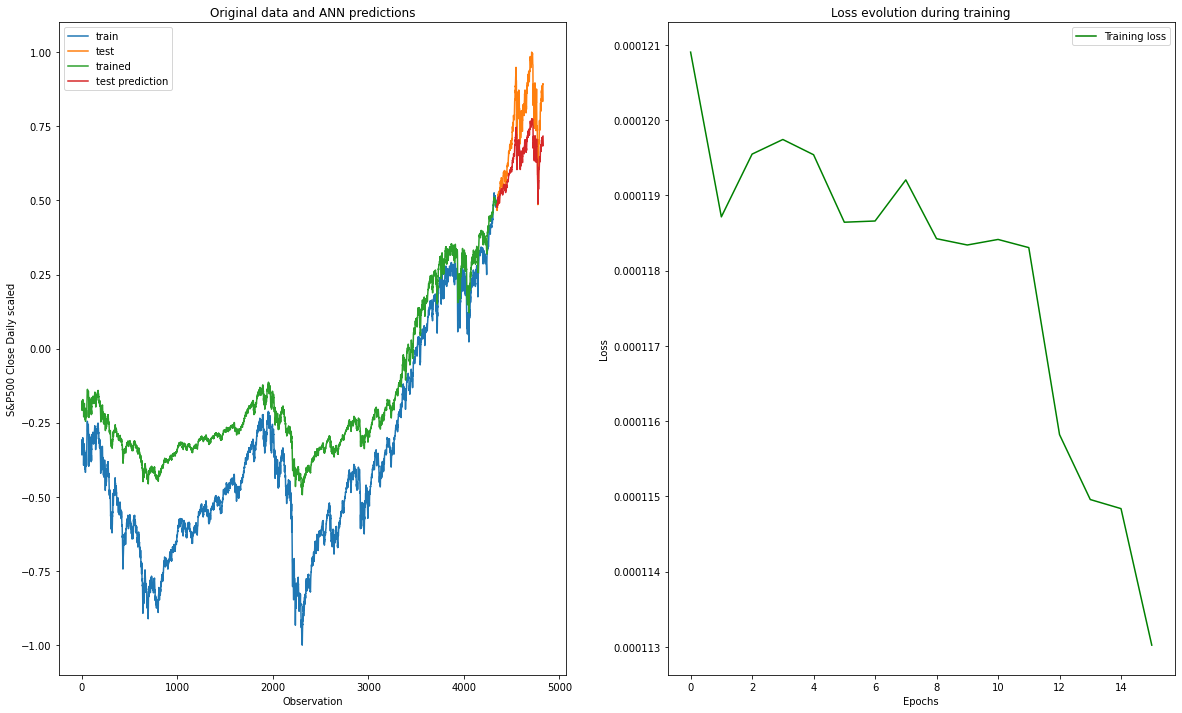

In [ ]:
display_ann(ann, history, best_window_size,
            p["batch_size"], train_scaled, test_scaled)